<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!yes | pip install -U --quiet selenium scikit-learn-intelex Pillow sklearn
!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r --quiet requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, itertools, shutil, requests, webbrowser, urllib.request, time, random
import PIL.Image

from IPython.core.display import Image
from statistics import mean, pstdev
from selenium import webdriver
from bs4 import BeautifulSoup

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_CUB = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/data/CUB/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

globalSize = 20
LEN_FOR_ONE_SCROLL = 20

N_WAY = 5
N_SHOT = 5
N_QUERY = 15

batchSize = 125 # size of the set of pairs

--- UTILS ---

In [3]:
def createListOfClasses(classesFile):

  """
  get set of all classes to be used in the support set from Ismael's text file
  """

  classes = []
  index=0

  for animal in classesFile.readlines():
    animal = animal.strip("\n").replace(" ", "")
    classes.append(animal)

  return classes

In [4]:
def getUa(mesurements, k=1):

  """
  get mean and incertitude from a list of mesurements, the first element in the list
  must be the title of the experiement.
  """

  title = mesurements[0]
  l = mesurements[1:]
  inv_n = 1.0/(len(l)-1)
  inv_ns = 1.0/pow(len(l), 0.5)
  m_ = round(mean(l), 2)
  dm2 = [pow(mi - m_, 2) for mi in l]
  pstd = pow(inv_n*sum(dm2), 0.5)
  u = round(k*pstd*inv_ns, 2)
  
  return title+str(m_) + "% +- " + str(u) + " (with 95% confidence)" if k!=1 else "", m_, u

def getUaList(listOfExperiences, k=1):

  for mesurements in listOfExperiences:
    string, m_, u = getUa(mesurements, k)
    print(string)

In [5]:
def saveFile(filename, data):
  file = open(PATH_MODEL+filename, "w+")
  for d in data:
    file.write(str(d)+"\n")
  file.close()

def showRegression(rangeOfData, data, degree):
  coef = np.polyfit(rangeOfData, data, degree)
  poly1d_fn = np.poly1d(coef) 
  plt.plot(rangeOfData, data, '-yo', rangeOfData, poly1d_fn(rangeOfData), '--k')
  plt.show()
  print("regression polynome :\n")
  print(np.poly1d(poly1d_fn))
  print("started at", data[0], "and ended at", data[-1])
  print("\n")

def showData(data, title, degree, saveInfo=[False, ""]):

  path = saveInfo[1]
  if saveInfo[0]:
    saveFile(path, data)

  numberOfIteration = range(0, len(data))

  plt.plot(numberOfIteration, data)
  plt.title(title)
  plt.show()
  showRegression(numberOfIteration, data, degree)

In [6]:
def getMatrixReport(labels, predicted_labels):
    print("\n")
    res = classification_report(labels, predicted_labels, target_names=["c"+str(i) for i in range(0, len(labels))],  output_dict=True)
    print(confusion_matrix(labels, predicted_labels))
    return res, res['accuracy']

--- IMAGE RETRIEVAL ---

In [7]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup


def getImages(classes):

  imagesNumber = 0

  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  print("downloading images...")

  for classe in tqdm(classes.split(",")):

    try:
      classeName = classe.replace(" ", "")
      os.makedirs(PATH_IMAGES+classeName)

      soup = getParser(classeName)
      img_tags = soup.find_all("img", class_="rg_i")

      for index in range(0, len(img_tags)):
        try:
            urllib.request.urlretrieve(img_tags[index]['src'], PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg")
            imagesNumber+=1
        except Exception as e:
            pass
    except:
      pass

  return imagesNumber

#don't work very well it seems
def resizeImages(classes):

  size = (300, 300)
  errorResize = 0
  for classe in tqdm(classes.split(",")):

    classeName = classe.replace(" ", "")
    for index in range(0, len(os.listdir(PATH_IMAGES+classeName))):

      infile = PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg"
      outfile = PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg"

      try:
        im = PIL.Image.open(infile)
        im.thumbnail(size, PIL.Image.ANTIALIAS)
        im.save(outfile)
      except IOError:
        errorResize+=1

  return errorResize

def getClassesImagesURLLIB(classes, download=True):

  imagesNumber = 0

  if download:
    imagesNumber = getImages(classes)

  print("transitionning to the resizing process...")
  errorResize = resizeImages(classes)
  
  print("\n"+str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes.split(","))) + " per classes")
  print(str(errorResize), " images couldn't be resized")

In [8]:
retreivalNotDone = False

classesFile = open(PATH_MODEL+"animals.txt")
classes = createListOfClasses(classesFile)
print("classes :", classes)

if retreivalNotDone:
  getClassesImagesURLLIB(classes, retreivalNotDone)
  retreivalNotDone = False

classes : ['Aardvark', 'Aardwolf', 'Africanbuffalo', 'Africanelephant', 'Africanleopard', 'Albatross', 'Alligator', 'Alpaca', 'Americanrobin', 'Amphibian', 'Anaconda', 'Angelfish', 'Anglerfish', 'Ant', 'Anteater', 'Antelope', 'Antlion', 'Ape', 'Aphid']


--- DATASET ---

In [9]:
def getNrandomClassesPaths(listClasses, n_way):

  paths = []
  for i in range(0, n_way):
    ridx = random.randint(0, len(listClasses)-1)
    paths.append(PATH_CUB+listClasses[ridx]+"/")
    listClasses.remove(listClasses[ridx])

  return paths

In [10]:
imageResize = (350, 350)

# each set is as follows : 
"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""

def getImageTensor(path):
  convert = transforms.ToTensor()
  return convert(PIL.Image.open(path).resize(imageResize))

def getFolderTensors(path, supportNumber, queryNumber, label):

  images = os.listdir(path)
  support_i, query_i = [], []

  for i in range(0, supportNumber):
    ridx = random.randint(0, len(images)-1)
    support_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])
  
  for i in range(0, queryNumber):
    ridx = random.randint(0, len(images)-1)
    query_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])

  return support_i, query_i

def getSets(paths, supportNumber, queryNumber):

  supportSet, querySet = [], []
  for label, path in enumerate(paths):
    Si, Qi = getFolderTensors(path, supportNumber, queryNumber, label)
    supportSet.append(Si)
    querySet.append(Qi)

  return supportSet, querySet

In [11]:
def getPair(c1, i, c2, j, setOfImages):

  I1 = [setOfImages[c1][i][0]]
  I2 = [setOfImages[c2][j][0]]
  s = 1.0 if c1 == c2 else 0.0

  return I1, I2, s

"""
For both PP and NP
compute cartesian product of set (without doublons).
For PP the sets are horizontal (images of same class)
For NP the sets are vertical (iamges of different class)

possible bias because PP = NP ?
"""

"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""

def getPP(setOfImages):

  PP = []
  for set_ in range(0, N_WAY):
    for offset in range(0, N_SHOT):
      for other in range(offset, N_SHOT):
        PP.append(getPair(set_, offset, set_, other, setOfImages))

  return PP

def getNP(setOfImages):

  NP = []
  for set_ in range(0, N_SHOT):
    for offset in range(0, N_WAY):
      for other in range(offset+1, N_WAY):
        NP.append(getPair(offset, set_, other, set_, setOfImages))

  return NP


def generatePNPairs(setOfImages):

  PP, NP = [], []
  PP = getPP(setOfImages)
  NP = getNP(setOfImages)

  print(len(PP), len(NP))
  return random.shuffle(PP + NP)

  # ------------------------

def getRandomPair(setOfImages):
  nbClasses = len(setOfImages)
  nbEx = len(setOfImages[0])
  ci1, e1 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1) 
  ci2, e2 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1)

  I1 = torch.stack([setOfImages[ci1][e1][0]])
  I2 = torch.stack([setOfImages[ci2][e2][0]])

  return I1, I2, 1.0 if ci1 == ci2 else 0.0

--- NETWORK ---

In [12]:
# taken from https://github.com/fangpin/siamese-pytorch/blob/master/model.py

# open question : does the backpropagation happen, and if yes, until where ?
# in order to avoid backprop on other component, we can just extrenalize the creation of the w vector ?
# EDIT : which is what I just did

"""
I1 --> CNN --> u
                \
                  |u-v| --> NN --> x --> s(x) --> L(.,.)
                /
I2 --> CNN --> v
"""

cuda_ = True

backbone = resnet18(pretrained=True)
combination = lambda u, v: torch.abs(u-v)               

modules=list(backbone.children())[:-1]

if cuda_:
  backbone=nn.Sequential(*modules).cuda() 
else:
  backbone=nn.Sequential(*modules)

def get_vector(image):

  image = image.cuda() if cuda_ else image
  return backbone(image).reshape(1, 512).squeeze(0)

def createCombinedVector(I1, I2):

  u = get_vector(I1)
  v = get_vector(I2)
  return combination(u, v)

class Siamese(nn.Module):

    def __init__(self):
      super(Siamese, self).__init__()
      self.metric = nn.Linear(512, 1)

    def forward(self, w):
      out = self.metric(w)
      out_normalized = torch.sigmoid(out)

      return out_normalized

if cuda_:
  model = Siamese().cuda()
else:
  model = Siamese()
  
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) #torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9, weight_decay=0.5) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
def getImages(query, image):

  if cuda_:
    query, image = query.cuda(), image.cuda()

  if query.dim() < 4:
    query = query.unsqueeze(0)
  
  if image.dim() < 4:
    image = image.unsqueeze(0)

  return query, image

def isCorrect(predictions, queryClass):
  pred_sorted = sorted(predictions, key=lambda tup: tup[-1], reverse=True)
  print("query is ", queryClass, " and prediction are :", list(map(lambda t: (t[0], t[1].cpu().numpy()[0]), pred_sorted[0:5])))
  return queryClass == pred_sorted[0][1]

def evaluate(supportSet, querySet):

  triplets = []
  correct = 0
  
  model.eval()
  with torch.no_grad():
    for queryInfo in list(itertools.chain(*querySet)):
      torch.cuda.empty_cache()
      query, queryClass = queryInfo
      for imageInfo in list(itertools.chain(*supportSet)):
        image, imageClass = imageInfo

        query, image = getImages(query, image)
        w = createCombinedVector(query, image)
        p = model(w)
        triplets.append((imageClass, p))
      
      predBoolean = isCorrect(triplets, queryClass)
      if predBoolean: correct+=1

  
  print("\n accuracy :", 100.0*correct/len(querySet))

  return 100.0*correct/len(querySet)

In [14]:
def saveModel(epoch, loss_value):

  torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': loss_value
  }, "/content/drive/MyDrive/Colab Notebooks/pipeline/model/model_check.pt")

def epoch(suppSet):

  lossForBatch = []
  for i in range(0, batchSize):

    #I1, I2, s = pairSet[i][0], pairSet[i][1], pairSet[i][2]
    #print(pairSet[i])
    I1, I2, s = getRandomPair(suppSet)
    w = createCombinedVector(I1, I2)
    out = model(w)
    s = torch.tensor([s]).cuda() if cuda_ else torch.tensor([s])

    optimizer.zero_grad()
    loss = nn.BCELoss()(out, s)
    loss.backward()
    optimizer.step()
    lossForBatch.append(loss.detach().cpu())

  return lossForBatch


validation = False
def training(supportSet, querySet):

  numberOfEpochs = 200
  #setOfPairs = generatePNPairs(supportSet)

  valFreq = 10
  bestAcc = 0.0
  bestModel = model.state_dict()

  losses = []
  val = []

  model.train()
  for epoch_i in tqdm(range(0, numberOfEpochs)):
    batchLoss = epoch(supportSet)
    losses.append(batchLoss)

    if epoch_i % valFreq == 0 and epoch_i != 0:

      saveModel(model, batchLoss[-1])
      
      if validation:
        validationAccuracy = evaluate(supportSet, querySet) # mettre un validation set
        val.append(validationAccuracy)

        if validationAccuracy > bestAcc:
          bestModel = model.state_dict()

  torch.save(bestModel, PATH_MODEL+"SN.pt") if validation else torch.save(model.state_dict(), PATH_MODEL+"SN.pt")

  return losses, val

In [15]:
listClassCUB = os.listdir(PATH_CUB)
supportClasses = getNrandomClassesPaths(listClassCUB, N_WAY)

supportSet, querySet = getSets(supportClasses, N_SHOT, N_QUERY)

In [ ]:
trainingNeeded = True

if trainingNeeded:
  losses = training(supportSet, querySet)
else:
  model.load_state_dict(torch.load(PATH_MODEL+"SN.pt"))
  print("model loaded")

  8%|▊         | 16/200 [00:58<11:10,  3.64s/it]

[4.475001335144043, 0.27084749937057495, 0.008845292963087559, 1.5800435543060303, 0.46194303035736084, 0.3616095185279846, 0.43393173813819885, 0.39841407537460327, 0.3791450262069702, 0.37770622968673706, 0.44643354415893555, 1.0272977352142334, 0.43992024660110474, 0.43169063329696655, 0.41205188632011414, 0.3740598261356354, 0.42329564690589905, 0.4143621027469635, 0.4339853525161743, 1.0241169929504395, 0.4068238437175751, 0.42443937063217163, 0.42517587542533875, 0.4191299080848694, 0.4623650312423706, 0.4519243538379669, 0.42256277799606323, 0.4350794851779938, 0.4229224622249603, 1.0712090730667114, 0.42907440662384033, 0.42006880044937134, 0.4269925057888031, 0.4268307387828827, 0.8302754759788513, 0.4745485782623291, 0.4279763996601105, 0.4224056303501129, 0.40039899945259094, 0.4214155673980713, 0.4036886394023895, 0.4191972613334656, 0.4213992953300476, 0.4293602406978607, 0.4361031651496887, 0.45340076088905334, 0.4274185597896576, 0.42896875739097595, 0.4121459424495697, 

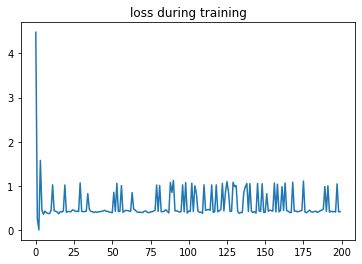

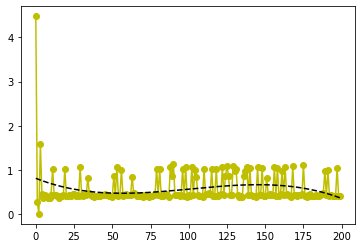

regression polynome :

            3             2
-5.547e-07 x + 0.0001681 x - 0.01371 x + 0.8133
started at 4.475001335144043 and ended at 0.42215532064437866




In [47]:
y = [yi[0].tolist() for yi in list(itertools.chain(*losses))]
print(y)
showData(y, "loss during training", 3)

In [48]:
accuracy = evaluate(supportSet, querySet)

query is  0  and prediction are : [(2, 0.37289965), (0, 0.37129846), (3, 0.3701201), (2, 0.36978206), (0, 0.3694774)]
query is  0  and prediction are : [(2, 0.37289965), (0, 0.37129846), (3, 0.37070873), (0, 0.3702268), (3, 0.3701201)]
query is  0  and prediction are : [(2, 0.3732593), (2, 0.37289965), (3, 0.37270132), (2, 0.37178764), (3, 0.3715691)]
query is  0  and prediction are : [(2, 0.3732593), (2, 0.37289965), (3, 0.37270132), (3, 0.37220204), (2, 0.37178764)]
query is  0  and prediction are : [(2, 0.3732593), (2, 0.37289965), (3, 0.37270132), (3, 0.37220204), (2, 0.37178764)]
query is  0  and prediction are : [(2, 0.3732593), (0, 0.37324944), (2, 0.37289965), (3, 0.37270132), (3, 0.37220204)]
query is  0  and prediction are : [(2, 0.3732593), (0, 0.37324944), (2, 0.3732309), (2, 0.37289965), (3, 0.37270132)]
query is  0  and prediction are : [(2, 0.3739445), (3, 0.37333375), (2, 0.3732593), (0, 0.37324944), (2, 0.3732309)]
query is  0  and prediction are : [(2, 0.3739445), (3,

In [ ]:
listOfExperiences = [
                     ["exp 1: ", 65, 65, 874, 241, -10, 3]
                    ]
getUaList(listOfExperiences, 2.776)